![Closed gate door (Emil Bruckner ©)](./emil-bruckner-o1jqBoyB9qY-unsplash.jpg)

In 2014, Dropout was introduced [@srivastava2014dropout] as a simple, yet effective way of regularizing neural networks. Dropout is conceptually simple: one randomly removes connections of neurons from the network. If a network can manage to learn the data well with a certain amount of disturbance (removed nodes), it can be said to have found a good generalisation. However, the implications of dropout are not quite as trivial. In this blog post, we will look at a simple model to gain some intuition into the effects of dropout (and how it compares to other forms of regularisation).

## Linear regression

In his main work on dropout [@srivastava2013improving], Srivasta shows that linear regression can be marginalised to become part of the training objective of e.g a linear regression. Quoting the theorem:

> Let $X \in \mathbb{R}^{N \times D}$ be a data matrix of $N$ data points. $\textbf{y} \in \mathbb{R}^{N}$ be a vector of the targets. Linear regression tries to find a $\textbf{w} \in \mathbb{R}^{D}$ that minimizes:
>  
> <center>$\vert\vert\textbf{y} - X\textbf{w}\vert\vert^2$</center>
> 
> When the input $X$ is dropped out such that any input dimension is retained with probability $p$, the input can be expressed as $R * X$ where $R \in {0, 1}^{N \times D}$ is a random matrix with $R_{ij} \sim Bernoulli(p)$ and $*$ denotes an element-wise product. Marginalizing the noise, the objective function becomes
> 
> <center>$minimize(w)$  $\mathbb{E}_{R \sim Bernoulli(p)} [\vert\vert\textbf{y}-(R*X)\textbf{w}\vert\vert^2]$</center>
>
> This reduces to
> <center>$minimize(w)$  $\vert\vert\textbf{y}-pX\textbf{w}\vert\vert^2+p(1-p)\vert\vert\Gamma\textbf{w}\vert\vert^2$</center>
> <br/>
> where $\Gamma = (diag(X^TX))^{1/2}$. Therefore, dropout with linear regression is equivalent, in expectation, to ridge regression with a particular form for $\Gamma$.

In other words, dropout becomes equivalent to ridge regression ($L^2$ regression loss) for linear regression.

## What is happening here?

We just went from randomly dropping neuron connections to behavior identical to a regularization loss. This is highly unintuitive. To gain some understanding, it might be best to look at some example of what those two mechanisms actually do.

One can express the $L^2$ norm as follows:

$f_{t}^{reg}(X) = f_{t}(X) + \frac{\lambda^{\prime}}{2}\vert\vert X \vert\vert^2_2$.

In essence, the $L^2$ norm adds a bias term to the function $f_t(X)$. We can see this effect by setting ourselves up with an example. Given $f(x) = I(x)$, $\lambda^{\prime} = 1$ and an initial matrix:

In [79]:
from IPython.display import HTML, display
from matrepr import to_html
import numpy as np

initial_matrix = np.array([[1, 1], [2, 3], [3, 7]])
display(HTML(to_html(initial_matrix_l2)))

,0,1
0,1,1
1,2,3
2,3,7


When we apply the $L^2$ norm, we will see slight growth of our initial matrix. This particularly impacts large values.

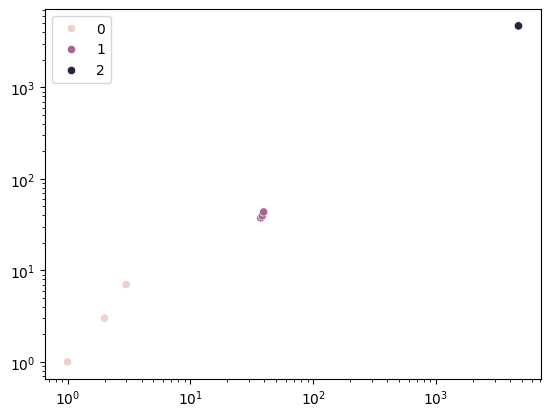

In [80]:
#| label: fig-l2-norm
#| fig-cap: "A scatterplot showing the effect of L2 norm. Each color represents one pass through the norm"

import matplotlib.pyplot as plt
import seaborn as sns

matrix_l2_1 = initial_matrix + (1/2)*np.sum(np.square(initial_matrix))
matrix_l2_2 = matrix_l2_1 + (1/2)*np.sum(np.square(matrix_l2_1))

result = np.vstack([initial_matrix, matrix_l2_1, matrix_l2_2])
x, y = zip(*result)

fig, ax = plt.subplots()

ax.set_yscale("log")
ax.set_xscale("log")
sns.scatterplot(x=x, y=y, ax=ax, hue=[i // 3 for i in range(9)])
plt.show()

We can see that after three iterations already, the regularization term has pulled together all points. Our outlier $\{3, 7\}$ has been eliminated. When applying marginalized dropout, instead of adding a bias term, we multiply $X$ by $\Gamma$

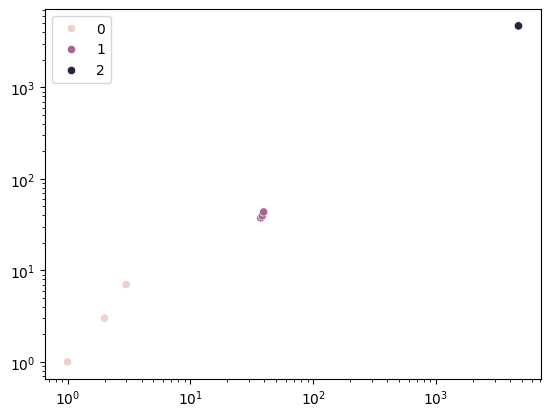

In [102]:
#| label: fig-dropout
#| fig-cap: "A scatterplot showing the effect of dropout. Each color represents one pass through dropout"

matrix_droput_1 = initial_matrix * np.sum(np.sqrt(np.power(np.diag(np.dot(initial_matrix,initial_matrix.T)), (1/2))))
matrix_droput_2 = matrix_droput_1 * np.sum(np.sqrt(np.power(np.diag(np.dot(matrix_droput_1,matrix_droput_1.T)), (1/2))))

result = np.vstack([initial_matrix, matrix_l2_1, matrix_l2_2])
x, y = zip(*result)

fig, ax = plt.subplots()

ax.set_yscale("log")
ax.set_xscale("log")
sns.scatterplot(x=x, y=y, ax=ax, hue=[i // 3 for i in range(9)])
plt.show()

From visible inspection we can see that the marginalized dropout works remarkably similar to the $L^2$ norm. We have come a little closer unveiling this conundrum. Both, $L^2$ norm and dropout work to push together points, penalizing large outliers. 

In the context of machine learning algorithms, this is important to find _any_ minimum and converge the loss function. To illustrate this further, one can look at a more complex 3 dimensional distribution. It would be hard-ish for a regression to find the valley among points. From @fig-multivariate-l2-norm we can see the $L^2$ norm will quickly collapse this distribution, helping us to find a minimum after 7 iterations.

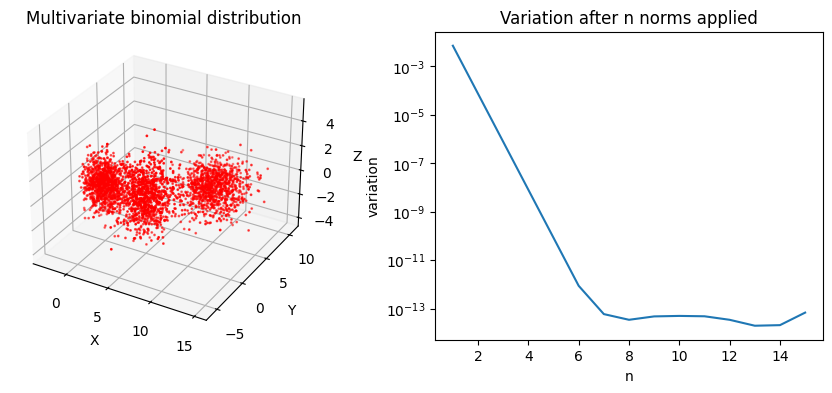

In [189]:
#| label: fig-multivariate-l2-norm
#| fig-cap: "Effects of L2 norm on a multivariate distribution"

from scipy.stats import multivariate_normal, variation

# Define the parameters of the three multivariate normal distributions
mu1 = np.array([0, 0, 0])
sigma1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
mu2 = np.array([5, 0, 0])
sigma2 = np.array([[2, 0, 0], [0, 2, 0], [0, 0, 2]])
mu3 = np.array([10, 5, 0])
sigma3 = np.array([[3, 0, 0], [0, 3, 0], [0, 0, 1]])

# Generate samples from the three multivariate normal distributions
data1 = multivariate_normal(mu1, sigma1).rvs(1000)
data2 = multivariate_normal(mu2, sigma2).rvs(1000)
data3 = multivariate_normal(mu3, sigma3).rvs(1000)

# Combine the samples into a single array
data = np.concatenate((data1, data2, data3))

# Calculate variation over steps
data_l2 = data.copy()
variations = []

for n in range(1, 16):
    data_l2 = data_l2 + np.linalg.norm(data_l2, 2)
    variations.append((n, variation(data_l2).mean()))

# Plot the distribution of the data
fig = plt.figure(figsize=(11, 4))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(data[:, 0], data[:, 1], data[:, 2], c='red', marker='o', s=1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.title.set_text('Multivariate binomial distribution')

ax2 = fig.add_subplot(1, 2, 2)
x, y = zip(*variations)
sns.lineplot(x=x, y=y, ax=ax2)
ax2.set_xlabel('n')
ax2.set_ylabel('variation')
ax2.set_yscale('log')
ax2.title.set_text('Variation after n norms applied')

plt.show()

## Applying theory to real (synthetic) data

We have a proof that $L^2$ and marginalised dropout are equivalent, and we have gained some intuition on why it works. It is time to put our formal ideas to the test with some empirical data. We will use the [moons dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) to evaluate for:

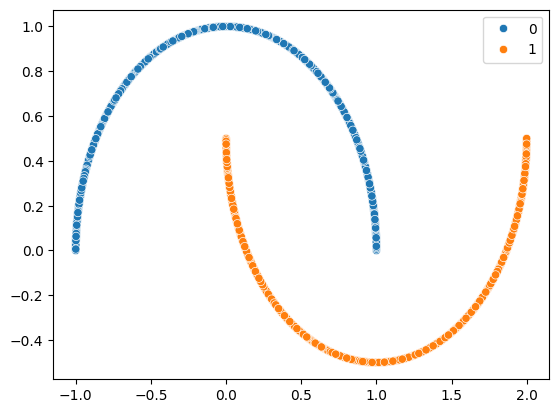

In [192]:
#| label: fig-moons-dataset
#| fig-cap: "A scatterplot of the moons dataset"

from sklearn.datasets import make_moons

X, labels = make_moons(1000)

fig, ax = plt.subplots()
x, y = zip(*X)
sns.scatterplot(x=x, y=y, hue=labels, ax=ax)
plt.show()

We can define a neural network to handle this task, a simple multi-layer perceptron suffices:

In [193]:
#| code-fold: false

import torch
import torch.nn

model = torch.nn.Sequential(
    torch.nn.Linear(2, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1)
)

An equivalent network with dropout looks like so:

In [194]:
#| code-fold: false

model_dropout = torch.nn.Sequential(
    torch.nn.Linear(2, 100),
    torch.nn.Dropout(),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.Dropout(),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1),
)

Following standard procedure for regression models, we split into train and evaluation sets:

In [196]:
#| code-fold: false

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33, random_state=42)

We opt for binary crossentropy as our loss, and simple stochastic gradient descent for evaluation. We train both networks for 200 epochs. Once training completes, we can evaluate on the test set. The results can be seen in @tbl-model-scores.

In [200]:
#| label: tbl-model-scores
#| tbl-cap: Table of models with their accuracy scores.

import torch.optim as optim
from torch.utils.data import TensorDataset
from sklearn.metrics import accuracy_score
from tabulate import tabulate

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.2)
optimizer_dropout = optim.SGD(model_dropout.parameters(), lr=0.001)

inps, tgts = torch.from_numpy(X_train.astype(np.float32)), torch.from_numpy(y_train.astype(np.float32))
trainloader = TensorDataset(inps,tgts)

for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

# print('Finished Training')

for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer_dropout.zero_grad()

        # forward + backward + optimize
        outputs = model_dropout(inputs)
        # print(outputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

# print('Finished Training Dropout')

inps_test = torch.from_numpy(X_test.astype(np.float32))

def binarize(input_array, threshold: float = 0.5):
    return torch.where(input_array < threshold, torch.tensor(0), torch.tensor(1))

model.eval() # enabling the eval mode to test with new samples.

# Run forward pass
with torch.no_grad():
    outputs = model(inps_test)
    y_pred = binarize(outputs).numpy()

model_dropout.eval()

# Run forward pass
with torch.no_grad():
    outputs = model_dropout(inps_test)
    y_pred_dropout = binarize(outputs).numpy()


table = [
    ["MLP", accuracy_score(y_pred, y_test)],
    ["MLP (Dropout)", accuracy_score(y_pred_dropout, y_test)]
]

display(HTML(tabulate(table, ["model_name", "accuracy_score"], tablefmt="html")))

model_name,accuracy_score
MLP,0.487879
MLP (Dropout),0.487879


To no surprise, both models have **exactly** the same accuracy score. This serves as further evidence the theorem holds.

## Caveats

While we have examined $\Gamma$, we have yet to look at our Bernoulli distribution $p(1-p)$. The highest level of regularization of dropout will be reached at $p = 0.5$, as this maximises our parabola (see @fig-parabola).

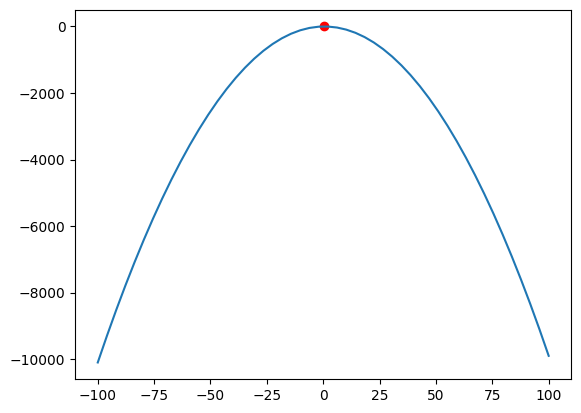

In [219]:
#| label: fig-parabola
#| fig-cap: "Parabola of the Bernoulli distribution"

x = np.linspace(-100, 100)
y = [p*(1-p) for p in x]

fig, ax = plt.subplots()
sns.lineplot(x=x, y=y, ax=ax)
ax.scatter(0.5, 0.25, color="red")
plt.show()

$p = 0.5$ is the default setting of `nn.Dropout`, which is why we saw exactly the same results in @tbl-model-scores. If we vary our $p$, we will vary the strength of our regularizer. 

This *sounds* profound, but it is not. Unlike the $L^2$ norm, varying $p$ actually means we will introduce noise into the network. @clara2306dropout discussed at length the implications of this noise. Quoting from their work, where $D2 = \Gamma$:

> Treatment of the corresponding iterative dropout scheme becomes, however, much harder. The analysis of dropout with Bernoulli distributions relies in part on the projection property D2 = D.

In stark contrast to the $L^2$ norm, dropout's variance may actually _"throw off"_ stochastic gradient descent from its trajectory, slowing, or in extreme cases, preventing convergence.

This makes intuitive sense. For dropout to be effective, a network needs to actually overfit. If a network has not yet overfitted, randomly dropping nodes seems like a **really** bad idea. Thus dropout should only be applied to sufficiently large problems. With this knowledge at hand, it becomes questionable wether marginalised dropout for linear regression is very useful.